In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath('../src'))
import numpy as np
import copy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d 
import math
import anyterrain as at
import time

from gurobipy import *

from IPython.core.debugger import Pdb

In [2]:
import logging
logger = logging.getLogger('debug')
logger.setLevel(logging.INFO)

fh = logging.FileHandler('anyplan.log')
fh.setLevel(logging.INFO)
formatter = logging.Formatter('%(message)s')
fh.setFormatter(formatter)
logger.addHandler(fh)

logTimes = 0

In [3]:
K_d_f = np.arange(1,10,1)
K_d_t = np.arange(1,10,1)
K_h = np.arange(1,10,1)
K_sigma_f = np.arange(0.1,1,0.1)
K_sigma_t = np.arange(0.1,1,0.1)

D = [0.1,0.2,0.3]
Sigma = [0.1,1.0]


for k_d_f in K_d_f:
    for k_d_t in K_d_t:
        if k_d_f >= k_d_t:
            continue
        for k_sigma_f in K_sigma_f:
            for k_sigma_t in K_sigma_t:
                if k_sigma_f <= k_sigma_t:
                    continue
                for k_h in K_h:
                    
                    found = True
                    for d in D:
                        for sigma in Sigma:
                            if (k_d_f - k_h) * d + sigma * k_sigma_f > 0 or (k_d_t - k_h) * d + sigma * k_sigma_t > 0:
                                found = found and False
                                continue
                            else:
                                if sigma < 0.5 and k_d_f * d + sigma* k_sigma_f > k_d_t * d + sigma* k_sigma_t:
                                    found = found and False
                                    continue
                                elif sigma > 0.5 and k_d_f * d + sigma* k_sigma_f < k_d_t * d + sigma* k_sigma_t:
                                    found = found and False
                                    continue
                
                if found == True:
                    print((k_d_f,k_d_t,k_h,k_sigma_f,k_sigma_t))

(1, 2, 9, 0.4, 0.1)
(1, 2, 9, 0.5, 0.1)
(1, 2, 9, 0.5, 0.2)
(1, 2, 9, 0.6, 0.1)
(1, 2, 9, 0.6, 0.2)
(1, 2, 9, 0.7000000000000001, 0.1)
(1, 2, 9, 0.7000000000000001, 0.2)
(1, 2, 9, 0.7000000000000001, 0.30000000000000004)
(1, 2, 9, 0.7000000000000001, 0.4)
(1, 2, 9, 0.8, 0.1)
(1, 2, 9, 0.8, 0.2)
(1, 2, 9, 0.8, 0.30000000000000004)
(1, 2, 9, 0.8, 0.4)
(1, 2, 9, 0.8, 0.5)
(1, 3, 9, 0.7000000000000001, 0.1)
(1, 3, 9, 0.8, 0.1)
(1, 3, 9, 0.8, 0.2)
(2, 3, 9, 0.4, 0.1)
(2, 3, 9, 0.5, 0.1)
(2, 3, 9, 0.5, 0.2)
(2, 3, 9, 0.6, 0.1)
(2, 3, 9, 0.6, 0.2)
(2, 3, 9, 0.6, 0.30000000000000004)
(2, 3, 9, 0.7000000000000001, 0.1)
(2, 3, 9, 0.7000000000000001, 0.2)
(2, 3, 9, 0.7000000000000001, 0.30000000000000004)
(2, 3, 9, 0.7000000000000001, 0.4)
(2, 4, 9, 0.7000000000000001, 0.1)
(3, 4, 9, 0.5, 0.1)
(3, 4, 9, 0.5, 0.2)
(3, 4, 9, 0.6, 0.1)
(3, 4, 9, 0.6, 0.2)
(3, 4, 9, 0.6, 0.30000000000000004)
(4, 5, 9, 0.4, 0.1)
(4, 5, 9, 0.5, 0.1)
(4, 5, 9, 0.5, 0.2)
(5, 6, 9, 0.4, 0.1)


### Create a world consisting of multiple planes. 

The result is a 2-D matrix *terrain*. Each line of the matrix represent a plane 

$$ax+by+cz+d=0$$

A line of the *terrain* matrix is 

$$[a, b, c, d, x_{min}, x_{max}, y_{min}, y_{max}, \sigma]$$

where $\sigma$ is the covariance of the plane

[[ 0.    0.    1.    0.    0.   10.    0.    5.    0.1 ]
 [ 0.    0.    1.   -3.    0.   10.   10.   20.    0.1 ]
 [ 0.    0.    1.   -0.15  1.    3.    5.    5.25  1.  ]
 [ 0.    0.    1.   -0.3   1.    3.    5.25  5.5   1.  ]
 [ 0.    0.    1.   -0.45  1.    3.    5.5   5.75  1.  ]
 [ 0.    0.    1.   -0.6   1.    3.    5.75  6.    1.  ]
 [ 0.    0.    1.   -0.75  1.    3.    6.    6.25  1.  ]
 [ 0.    0.    1.   -0.9   1.    3.    6.25  6.5   1.  ]
 [ 0.    0.    1.   -1.05  1.    3.    6.5   6.75  1.  ]
 [ 0.    0.    1.   -1.2   1.    3.    6.75  7.    1.  ]
 [ 0.    0.    1.   -1.35  1.    3.    7.    7.25  1.  ]
 [ 0.    0.    1.   -1.5   1.    3.    7.25  7.5   1.  ]
 [ 0.    0.    1.   -1.65  1.    3.    7.5   7.75  1.  ]
 [ 0.    0.    1.   -1.8   1.    3.    7.75  8.    1.  ]
 [ 0.    0.    1.   -1.95  1.    3.    8.    8.25  1.  ]
 [ 0.    0.    1.   -2.1   1.    3.    8.25  8.5   1.  ]
 [ 0.    0.    1.   -2.25  1.    3.    8.5   8.75  1.  ]
 [ 0.    0.    1.   -2.4   1.  

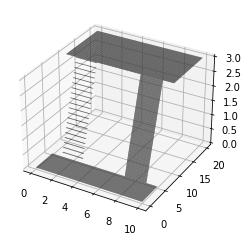

In [4]:
fig = plt.figure(1)
ax = fig.gca(projection='3d')
terrain = at.Terrain(ax,0)
print(terrain.terrainPlanes)

### Create a point cloud to simulate the LiDAR measurements in the format of Python dictionary. 

The key is a tuple $(x,y)$ which is the position of the point. The content of the item is the corresponding altitude $z$ and covariance $\sigma$. The point in the point cloud is 

$$P_i = (x_i,y_i):\begin{cases} z_i \\ \sigma_i \end{cases}  $$

In this way, the environment is discretized. By this Python dict structure, it is easy to check if one point exists and its elevation and covariance

In [5]:
class Point:
    def __init__(self,z,sigma):
        self.z = z
        self.sigma = sigma

def generatePointCloud(terrainPlanes):
    X = np.arange(0,10,0.1)
    Y = np.arange(0,20,0.1)
    X = np.append(X,10)
    Y = np.append(Y,20)
    pointCloud = {}
    
    for x in X:
        for y in Y:
            x = round(x,2)
            y = round(y,2)
            for i in range(terrainPlanes.shape[0]):
                if terrainPlanes[i,4] <= x < terrainPlanes[i,5] and terrainPlanes[i,6] <= y < terrainPlanes[i,7]:
                    pointCloud[(x,y)] = Point((-terrainPlanes[i,3]-terrainPlanes[i,0]*x-terrainPlanes[i,1]*y)/terrainPlanes[i,2],terrainPlanes[i,8])           
                    break
    return pointCloud
                    
pointCloud = generatePointCloud(terrain.terrainPlanes)

testX = 1.0
testY = 1.0
print("The Z of the point ({},{}) is {}. Its sigma is {}".format(testX,testY,pointCloud[(testX,testY)].z,pointCloud[(testX,testY)].sigma))

print((testX,testY) in pointCloud.keys())

The Z of the point (1.0,1.0) is -0.0. Its sigma is 0.1
True


### Define Anymal state node $N$
This node will be the basic element in the $A^*$ search tree. It records each node's $f$, $g$, $h$ and its parent. The tree is defined by two Python dictionaries which are open list and closed list respectively whose key is 

$$ N_i = ((x_0,y_0,z_0,\gamma_0)...(x_3,y_3,z_3,\gamma_3)): \begin{cases} parent_i \\ f_i\\ g_i\\h_i \\x_b\\y_b\\\psi_b\end{cases}$$ 

where $x_*$ denotes the $*^{th}$ foot's position, $x_b$ denotes the position of the torso, $\psi_b$ denotes the heading of the torso. $\gamma=0$ denotes a once-touch while $\gamma=1$ denotes a twice-touch. 

In the code, we use Python dict structure to express the node / search tree to take advantage of its fast look-up property

In [6]:
class AnymalStateNode:
    def __init__(self,parentIndex,g,h,node,action,legID,nodeID):
        self.parent = parentIndex
        self.g = g
        self.h = h
        self.f = g + h
        self.x_b = (node[0][0] + node[1][0] + node[2][0] + node[3][0])/4.0
        self.y_b = (node[0][1] + node[1][1] + node[2][1] + node[3][1])/4.0
        
        psi0 = math.atan2(node[0][1]-node[2][1],node[0][0]-node[2][0])
        psi1 = math.atan2(node[1][1]-node[3][1],node[1][0]-node[3][0])
        self.psi_b = (psi0 + psi1) / 2.0
        
        self.action = action
        self.legID = legID
        self.nodeID = nodeID
        
#         print("[AnymalStateNode] The heading is {}".format(self.psi_b))

In [7]:
test = ((0.0,1.5,0.0,False),(0.3,1.5,0.0,False),(0.0,0.0,0.0,False),(0.3,0.0,0.0,False))
print(test[0][0])

0.0


### $A^*$ algorithm

The search tree consists of two lists, which are the open list $L_O$ and the closed list $L_C$

$$ L_O = [... N_2, N_{65}, N_{33}, ...] $$
$$ L_C = [... N_1, N_{6}, N_{7}, ...] $$

At one node, for example $N_i$, we iterate all the possible action $a_j$ to explore the possible feasible node. In this example, the actions consist of different combination of $\Delta x \in [-0.1,0,0.1]$, $\Delta y\in[0.1,0.2]$ and $\gamma \in [0,1]$

If the action $a_j$ can lead the robot to a new feasible node $N_k$, then we add $N_k$ to $L_O$ and set its parent as $N_i$.

In the following example, we have three options. The index for each option is

$$ J = D + \sigma$$

If we select a double touch,

$$ J = 1.5D + 0.1\sigma$$

<img src="../action_demo.jpg">

So, the index for action 1 is: $0.2 + 1.1 = 1.3$

the index for action 2 is: $ 0.1\times1.5+0.1 + 1\times0.1 + 0.1 = 0.45$

the index for action 3 is: $0.35 + 0.2 = 0.55$

In [8]:
class AnymalAStar:
    def __init__(self,pointCloud,start,goal):
        self.pointCloud = pointCloud
        self.bodyLength = 1.5
        self.bodyWidth = 0.3
        
        self.start = self.fourLegsPosition(start)
        self.goal = self.fourLegsPosition(goal)
        
        self.goal_found = self.goal
        
        self.nodeID = 0
        
        self.openList = {}
        self.closedList = {}
        self.numSearchTimes = 0
        
        self.k_d_false = 1.0
        self.k_d_true = 2.0 #0.5
        self.k_h = 9.0
        self.k_sigma_true = 0.1
        self.k_sigma_false = 0.9 # 0.1
        print("The start node is {}".format(self.start))
        print("The goal node is {}".format(self.goal))

    def fourLegsPosition(self,basePosition):
        psi = basePosition[2]
        basePosition_e = np.array([basePosition[0],basePosition[1]])
        R_B_E = np.array([[math.cos(psi),-math.sin(psi)],[math.sin(psi),math.cos(psi)]])
        
        LF_b = np.array([self.bodyLength/2.0,self.bodyWidth/2.0])
        RF_b = np.array([self.bodyLength/2.0,-self.bodyWidth/2.0])
        LH_b = np.array([-self.bodyLength/2.0,self.bodyWidth/2.0])
        RH_b = np.array([-self.bodyLength/2.0,-self.bodyWidth/2.0])
        
                    
        LF_e = basePosition_e + R_B_E.dot(LF_b)
        LF_e[0] = round(LF_e[0],1)
        LF_e[1] = round(LF_e[1],1)
        key = ( LF_e[0], LF_e[1])
        
        if key in self.pointCloud.keys():
            LF_key = (LF_e[0],LF_e[1],round(self.pointCloud[key].z,1),False)
        else:
            print('[initialization] LF foot is invalid')
            return
        
        RF_e = basePosition_e + R_B_E.dot(RF_b)
        RF_e[0] = round(RF_e[0],1)
        RF_e[1] = round(RF_e[1],1)
        key = ( RF_e[0], RF_e[1])
        
        if key in self.pointCloud.keys():
            RF_key = (RF_e[0],RF_e[1],round(self.pointCloud[key].z,1),False)
        else:
            print('[initialization] RF foot is invalid')
            return
        
        LH_e = basePosition_e + R_B_E.dot(LH_b)
        LH_e[0] = round(LH_e[0],1)
        LH_e[1] = round(LH_e[1],1)
        key = ( LH_e[0], LH_e[1])
        
        if key in self.pointCloud.keys():
            LH_key = (LH_e[0],LH_e[1],round(self.pointCloud[key].z,1),False)
        else:
            print('[initialization] LH foot is invalid')
            return
        
        RH_e = basePosition_e + R_B_E.dot(RH_b)
        RH_e[0] = round(RH_e[0],1)
        RH_e[1] = round(RH_e[1],1)
        key = ( RH_e[0], RH_e[1])
        
        if key in self.pointCloud.keys():
            RH_key = (RH_e[0],RH_e[1],round(self.pointCloud[key].z,1),False)
        else:
            print('[initialization] RH foot is invalid')
            return
        return (LF_key,RF_key,LH_key,RH_key)
   
        
    def run(self):
        # add the start point to the open list. Its g = 0, h is an estimate distance towards the goal
        self.openList[self.start] = AnymalStateNode(self.start,0,self.getH(self.start),self.start,[],'RH',self.nodeID)
        
        while len(self.openList) > 0:
            if self.numSearchTimes > 10000:
                print("A* stucks and failed!")
                return False
            
            self.numSearchTimes = self.numSearchTimes + 1
            # find the minimum element and stand on it. Then, search its children          
            currentNode = self.moveToMinNode()
            
#             print("[run {}] move to {} ".format(self.numSearchTimes,currentNode))
#             print("[run {}] open list is {} ".format(self.numSearchTimes,self.openList))
            
            if self.searchChildren(currentNode):
                print("A* found the path")
                break
        #print(self.closedList)
    
    # Based on current node, we search its possible children (feasible nodes) and add valid children to
    # the open list and do the loop until we reach the goal
    def searchChildren(self,currentNode):
        actions = [(deltaX_b,deltaY_b,gamma) for deltaX_b in [0.0,0.2] for deltaY_b in [-0.1,0,0.1] \
                   for gamma in [False,True]]
    
        numOfChildern = 0
        children=[]
        
        if self.numSearchTimes < logTimes:
            logger.info("")
            logger.info("The parent is ({} from {}) {} legID = {} g = {}, \
            h = {}, f = {}".format(self.closedList[currentNode].nodeID,\
                                   self.closedList[self.closedList[currentNode].parent].nodeID,\
                                   currentNode,self.closedList[currentNode].legID,\
                                   self.closedList[currentNode].g,self.closedList[currentNode].h,\
                                   self.closedList[currentNode].f))
        
        for ii,act in enumerate(actions):
            actionValid,child,legID, actionKey = self.checkAction(currentNode,act)
        
            if self.numSearchTimes < logTimes:
                logger.info("[{}] The action is {}".format(ii,act))
            if actionValid == False:
                if self.numSearchTimes < logTimes:
                    logger.info("Action invalid key = {}".format(actionKey))
                continue
            # Here we have found a valid child of the current node. We need to check if this child is 
            # already in the open list or closed list
            if child in self.closedList:
                continue
                if self.numSearchTimes < logTimes:
                    logger.info("The action leads to closed list")

            elif child in self.openList:
                # Check if we need to change the child's parent
#                 print("[searchChildren] Found a child")
                if self.openList[child].g > self.getG(currentNode,child,act):
                    self.openList[child].parent = currentNode
                    self.openList[child].g = self.getG(currentNode,child,act)
                    self.openList[child].f = self.openList[child].g + self.openList[child].h
                    self.openList[child].action = act
                    self.openList[child].legID = legID
                    
                    if self.numSearchTimes < logTimes:
                        logger.info("The child (existing id = {}) is {}. \
                        g = {} h = {} f = {}".format(self.openList[child].nodeID,\
                                                     child,self.openList[child].g,\
                                                     self.openList[child].h,\
                                                     self.openList[child].f))
                        
                    numOfChildern = numOfChildern + 1
                    children.append(child)
            else:
                self.nodeID = self.nodeID + 1
                self.openList[child] = AnymalStateNode(currentNode,self.getG(currentNode,child,act),\
                                                       self.getH(child),child,act,legID,self.nodeID)
                children.append(child)
                numOfChildern = numOfChildern + 1
                
                if self.numSearchTimes < logTimes:
                    logger.info("The child (new id = {})  is {}. \
                    g = {} h = {} f = {}".format(self.openList[child].nodeID,\
                                                 child,self.openList[child].g,\
                                                 self.openList[child].h,\
                                                 self.openList[child].f))
                
#             if child == self.goal:
            if self.checkTerminal(child):
                print("Found the path")
#                 print(child)
                self.closedList[child] = copy.deepcopy(self.openList[child])
                self.openList.pop(child)
                self.goal_found = child
                return True
        
        return False
        
        
        
    # This is the the heuristic of the A*. In this situation, it is the estmation distance between
    # the node and the goal. In theory, it should be less than the real distance which can help A* 
    # converge to the optimal result
    def getH(self,node):
        h0 =  math.sqrt((node[0][0] - self.goal[0][0])**2 + (node[0][1] - self.goal[0][1])**2)
        h1 =  math.sqrt((node[1][0] - self.goal[1][0])**2 + (node[1][1] - self.goal[1][1])**2)
        h2 =  math.sqrt((node[2][0] - self.goal[2][0])**2 + (node[2][1] - self.goal[2][1])**2)
        h3 =  math.sqrt((node[3][0] - self.goal[3][0])**2 + (node[3][1] - self.goal[3][1])**2)
        
        return (h0 + h1 + h2 + h3) * self.k_h # 2.0

    
    
    # This function finds the node with minumum score in the open list
    # Once it is found, it will be moved to the closed list, which means we stand on this node
    def moveToMinNode(self):
        # NOTE: use deepcopy to move elements from dict1 to dict2!! Otherwise, it is just a link
        # print("[moveToMinNode] run")
        minIndex = min(self.openList, key=lambda p: self.openList[p].f)
        self.closedList[minIndex] = copy.deepcopy(self.openList[minIndex])
        self.openList.pop(minIndex)
        return minIndex
    
    
    # This function checks if the action can guide the robot from current node to a feasible node in the map
    def checkAction(self,currentNode,action):
        valid = False
        child = ('nan','nan','nan','nan','nan')
        legID = ''
        
        # Calculate the foot's position in Earth frame and check if the point exists
        psi = self.closedList[currentNode].psi_b
        deltaPosition_b = np.array([action[0],action[1]])
        R_B_E = np.array([[math.cos(psi),-math.sin(psi)],[math.sin(psi),math.cos(psi)]])
        
        if self.closedList[currentNode].legID == 'LF':
            currentFootXY = np.array([currentNode[1][0],currentNode[1][1]])
            currentFootZ = currentNode[1][2]
        elif self.closedList[currentNode].legID == 'RF':
            currentFootXY = np.array([currentNode[2][0],currentNode[2][1]])
            currentFootZ = currentNode[2][2]
        elif self.closedList[currentNode].legID == 'LH':
            currentFootXY = np.array([currentNode[3][0],currentNode[3][1]])
            currentFootZ = currentNode[3][2]
        elif self.closedList[currentNode].legID == 'RH':
            currentFootXY = np.array([currentNode[0][0],currentNode[0][1]])
            currentFootZ = currentNode[0][2]
        else:
            print("[checkAction] Reach unexisted foot 0!")
            
        targetPositionXY = currentFootXY + R_B_E.dot(deltaPosition_b)
        targetPositionXY[0] = round(targetPositionXY[0],1)
        targetPositionXY[1] = round(targetPositionXY[1],1)
        

        
        
#         print("[checkAction {}] psi is {} ".format(self.numSearchTimes,psi))
#         print("[checkAction {}] delta_x is {} ".format(self.numSearchTimes,deltaPosition_b))
#         print("[checkAction {}] R_B_E  {} ".format(self.numSearchTimes,R_B_E))
#         print("[checkAction {}] The footPosition in earth is {} ".format(self.numSearchTimes,R_B_E.dot(deltaPosition_b)))
        
        key = (round(targetPositionXY[0],2),round(targetPositionXY[1],1))
#         print("The key of the action is {}".format(key))
        
        if key in self.pointCloud.keys():
            # If the point exists, check if it violates the Anymal's geometric constraints
            if abs(currentFootZ - self.pointCloud[key].z)<0.3:
                newFootPosition = (round(targetPositionXY[0],1),round(targetPositionXY[1],1),\
                                   round(self.pointCloud[key].z,1),action[2])
#                 print("test0")
                if self.closedList[currentNode].legID == 'RH':
                    nodeKey = (newFootPosition,currentNode[1],currentNode[2],currentNode[3])
                    legID = 'LF'
#                     print("test1")
                elif self.closedList[currentNode].legID == 'LF':
                    nodeKey = (currentNode[0],newFootPosition,currentNode[2],currentNode[3])
                    legID = 'RF'
#                     print("test2")
                elif self.closedList[currentNode].legID == 'RF':
                    nodeKey = (currentNode[0],currentNode[1],newFootPosition,currentNode[3])
                    legID = 'LH'
#                     print("test3")
                elif self.closedList[currentNode].legID == 'LH':
                    nodeKey = (currentNode[0],currentNode[1],currentNode[2],newFootPosition)
                    legID = 'RH'
#                     print("test4")
                else:
                    print("[checkAction] Reach unexisted foot 1!")
                    
                if len(nodeKey) != 4:
                    print("[checkAction] nodeKey generation is wrong!")
                
#                 print("[checkAction {}] The parent is {}".format(self.numSearchTimes,currentNode))
#                 print("[checkAction {}] The action is {}".format(self.numSearchTimes,action))
#                 print("[checkAction {}] The child is {}".format(self.numSearchTimes,nodeKey))
#                 print("The nodeKey is {}".format(nodeKey))
                if self.checkFeetPosition(nodeKey):
                    valid = True
                    child = nodeKey
#                     print("test5")
        return valid, child, legID, key
    
    # This function checks if the four feet are within the boundary
    def checkFeetPosition(self,nodeKey):
        
        x_b = (nodeKey[0][0] + nodeKey[1][0] + nodeKey[2][0] + nodeKey[3][0])/4.0
        y_b = (nodeKey[0][1] + nodeKey[1][1] + nodeKey[2][1] + nodeKey[3][1])/4.0
        psi0 = math.atan2(nodeKey[0][1]-nodeKey[2][1],nodeKey[0][0]-nodeKey[2][0])
        psi1 = math.atan2(nodeKey[1][1]-nodeKey[3][1],nodeKey[1][0]-nodeKey[3][0])
        psi_b = (psi0 + psi1) / 2.0
        
        R_E_B = np.array([[math.cos(psi_b),math.sin(psi_b)],[-math.sin(psi_b),math.cos(psi_b)]])
        
#         print(nodeKey)
        v_LF = R_E_B.dot(np.array([nodeKey[0][0] - x_b, nodeKey[0][1] - y_b]))
        v_RF = R_E_B.dot(np.array([nodeKey[1][0] - x_b, nodeKey[1][1] - y_b]))
        v_LH = R_E_B.dot(np.array([nodeKey[2][0] - x_b, nodeKey[2][1] - y_b]))
        v_RH = R_E_B.dot(np.array([nodeKey[3][0] - x_b, nodeKey[3][1] - y_b]))
        
#         print("[checkFeetPosition {}] v_LF is {} ".format(self.numSearchTimes,v_LF))
#         print("[checkFeetPosition {}] v_RF is {} ".format(self.numSearchTimes,v_RF))
#         print("[checkFeetPosition {}] v_LH is {} ".format(self.numSearchTimes,v_LH))
#         print("[checkFeetPosition {}] v_RH is {} ".format(self.numSearchTimes,v_RH))
#         print("[checkFeetPosition {}] The base center is ({},{}) ".format(self.numSearchTimes,x_b,y_b))
        
        if max(abs(v_LF[0]),abs(v_RF[0]),abs(v_LH[0]),abs(v_RH[0])) > 0.95 \
        or min(abs(v_LF[0]),abs(v_RF[0]),abs(v_LH[0]),abs(v_RH[0])) < 0.50:
#             print("test6")
            return False
        
        
        if max(abs(v_LF[1]),abs(v_RF[1]),abs(v_LH[1]),abs(v_RH[1])) > 0.3 \
        or min(abs(v_LF[1]),abs(v_RF[1]),abs(v_LH[1]),abs(v_RH[1])) < 0.02:
#             print("test7")
            return False 
        
        return True
    
    
    
    # This function calculates the g value of the child when there is a movement from the parent to the child
    # When the action is once-touch, the score is just distance + covariance
    # If it is a two-touch action, we penalize the distance by 1.5 and decrease covariance score by 0.1
    # So it is a balance between the fast touch and the risk
    def getG(self,parent,child,action):
        if self.closedList[parent].legID == 'RH':
            key = (child[0][0],child[0][1])
            distance = math.sqrt((parent[0][0] - child[0][0])**2 + (parent[0][1] - child[0][1])**2)
        elif self.closedList[parent].legID == 'LF':
            key = (child[1][0],child[1][1])
            distance = math.sqrt((parent[1][0] - child[1][0])**2 + (parent[1][1] - child[1][1])**2)
        elif self.closedList[parent].legID == 'RF':
            key = (child[2][0],child[2][1])
            distance = math.sqrt((parent[2][0] - child[2][0])**2 + (parent[2][1] - child[2][1])**2)
        elif self.closedList[parent].legID == 'LH':
            key = (child[3][0],child[3][1])
            distance = math.sqrt((parent[3][0] - child[3][0])**2 + (parent[3][1] - child[3][1])**2)
        else:
            print("[getG] Reach unexisted foot")

        if action[2] == 0:
            value = distance * self.k_d_false + self.k_sigma_false * self.pointCloud[key].sigma
        elif action[2] == 1:
            value = distance * self.k_d_true + self.k_sigma_true * self.pointCloud[key].sigma
        else:
            print("Warning!! invalid action")
        return self.closedList[parent].g + value
    
    def getOptimalPath(self):
        parent = self.goal_found
        optimalPath = [parent]
        while parent != self.start:
            parent = self.closedList[parent].parent
            optimalPath.append(parent)
        return optimalPath
    
    def checkTerminal(self,node):
        x_f = (self.goal[0][0] + self.goal[1][0] + self.goal[2][0] + self.goal[3][0])/4.0
        y_f = (self.goal[0][1] + self.goal[1][1] + self.goal[2][1] + self.goal[3][1])/4.0
        
        x_node = (node[0][0] + node[1][0] + node[2][0] + node[3][0])/4.0
        y_node = (node[0][1] + node[1][1] + node[2][1] + node[3][1])/4.0
        
#         if self.numSearchTimes == 1:
#             print("The goal position is ({},{})".format(x_f,y_f))
        
        
        if math.sqrt((x_f-x_node)**2 + (y_f - y_node)**2) < 0.2:
            return True
        else:
            return False
        
    def plotOptimalPath(self,figNum):
        optimalPath = self.getOptimalPath()
        optimalPathOneTouchArray = np.zeros((3,len(optimalPath)))
        optimalPathDoubleTouchArray = np.zeros((3,len(optimalPath)))
        pointerOneTouch = 0
        pointerDoubleTouch = 0
        for i, node in enumerate(optimalPath):
            if anyAStar.closedList[node].legID == 'LF' and node[0][3] == False:
                optimalPathOneTouchArray[0,pointerOneTouch] = node[0][0]
                optimalPathOneTouchArray[1,pointerOneTouch] = node[0][1]
                optimalPathOneTouchArray[2,pointerOneTouch] = node[0][2]
                pointerOneTouch = pointerOneTouch + 1
            elif anyAStar.closedList[node].legID == 'RF' and node[1][3] == False:
                optimalPathOneTouchArray[0,pointerOneTouch] = node[1][0]
                optimalPathOneTouchArray[1,pointerOneTouch] = node[1][1]
                optimalPathOneTouchArray[2,pointerOneTouch] = node[1][2]
                pointerOneTouch = pointerOneTouch + 1
            elif anyAStar.closedList[node].legID == 'LH' and node[2][3] == False:
                optimalPathOneTouchArray[0,pointerOneTouch] = node[2][0]
                optimalPathOneTouchArray[1,pointerOneTouch] = node[2][1]
                optimalPathOneTouchArray[2,pointerOneTouch] = node[2][2]
                pointerOneTouch = pointerOneTouch + 1
            elif anyAStar.closedList[node].legID == 'RH' and node[3][3] == False:
                optimalPathOneTouchArray[0,pointerOneTouch] = node[3][0]
                optimalPathOneTouchArray[1,pointerOneTouch] = node[3][1]
                optimalPathOneTouchArray[2,pointerOneTouch] = node[3][2]
                pointerOneTouch = pointerOneTouch + 1
            elif anyAStar.closedList[node].legID == 'LF' and node[0][3] == True:
                optimalPathDoubleTouchArray[0,pointerDoubleTouch] = node[0][0]
                optimalPathDoubleTouchArray[1,pointerDoubleTouch] = node[0][1]
                optimalPathDoubleTouchArray[2,pointerDoubleTouch] = node[0][2]
                pointerDoubleTouch = pointerDoubleTouch + 1
            elif anyAStar.closedList[node].legID == 'RF' and node[1][3] == True:
                optimalPathDoubleTouchArray[0,pointerDoubleTouch] = node[1][0]
                optimalPathDoubleTouchArray[1,pointerDoubleTouch] = node[1][1]
                optimalPathDoubleTouchArray[2,pointerDoubleTouch] = node[1][2]
                pointerDoubleTouch = pointerDoubleTouch + 1
            elif anyAStar.closedList[node].legID == 'LH' and node[2][3] == True:
                optimalPathDoubleTouchArray[0,pointerDoubleTouch] = node[2][0]
                optimalPathDoubleTouchArray[1,pointerDoubleTouch] = node[2][1]
                optimalPathDoubleTouchArray[2,pointerDoubleTouch] = node[2][2]
                pointerDoubleTouch = pointerDoubleTouch + 1
            elif anyAStar.closedList[node].legID == 'RH' and node[3][3] == True:
                optimalPathDoubleTouchArray[0,pointerDoubleTouch] = node[3][0]
                optimalPathDoubleTouchArray[1,pointerDoubleTouch] = node[3][1]
                optimalPathDoubleTouchArray[2,pointerDoubleTouch] = node[3][2]
                pointerDoubleTouch = pointerDoubleTouch + 1


        pointerOneTouch = pointerOneTouch -1
        pointerDoubleTouch = pointerDoubleTouch -1

        plt.rcParams["figure.figsize"]=20,20
        fig = plt.figure(figNum)
        ax = fig.gca(projection='3d')

        terrain.plotPlanes(ax,terrain.terrainPlanes)

        ax.scatter(optimalPathOneTouchArray[0,0:pointerOneTouch],optimalPathOneTouchArray[1,0:pointerOneTouch],optimalPathOneTouchArray[2,0:pointerOneTouch],color = 'red',s=40)
        ax.scatter(optimalPathDoubleTouchArray[0,0:pointerDoubleTouch],optimalPathDoubleTouchArray[1,0:pointerDoubleTouch],optimalPathDoubleTouchArray[2,0:pointerDoubleTouch],color = 'green',s=40)


        ax.set_xlim([0,10])
        ax.set_ylim([0,20])
        ax.set_zlim([0,5])
        plt.show()
        
    def plotSearchProgress(self,figNum):
        searchedPoints = np.zeros((3,len(self.closedList)))
        
        for i,node in enumerate(self.closedList):
            searchedPoints[0,i] = node[0][0] 
            searchedPoints[1,i] = node[0][1]
            searchedPoints[2,i] = node[0][2]

        plt.rcParams["figure.figsize"]=20,20
        fig = plt.figure(figNum)
        ax = fig.gca(projection='3d')

        terrain.plotPlanes(ax,terrain.terrainPlanes)
        ax.scatter(searchedPoints[0,:],searchedPoints[1,:],searchedPoints[2,:])

In [9]:




# goal = ((2.0,18.0,3.0,False),(2.3,18.0,3.0,False),(2.0,16.5,3.0,False),(2.3,16.5,3.0,False))


# On planes
# start = ((0.0,1.5,0.0,False),(0.3,1.5,0.0,False),(0.0,0.0,0.0,False),(0.3,0.0,0.0,False))
# goal = ((1.5,4.9,0.0,False),(1.8,4.9,0.0,False),(1.5,3.4,0.0,False),(1.8,3.4,0.0,False))

# on stairs
# start = ((1.5,4.9,0.0,False),(1.8,4.9,0.0,False),(1.5,3.4,0.0,False),(1.8,3.4,0.0,False))
# goal = ((1.5,12,3.0,False),(1.8,12.0,3.0,False),(1.5,10.5,3.0,False),(1.8,10.5,3.0,False))

# From plane to stairs
# start = ((0.0,1.5,0.0,False),(0.3,1.5,0.0,False),(0.0,0.0,0.0,False),(0.3,0.0,0.0,False))
# goal = ((1.5,5.6,0.45,True),(1.8,5.6,0.45,True),(1.5,4.1,0,False),(1.8,4.1,0,False))

# From start to end
# start = ((0.0,1.5,0.0,False),(0.3,1.5,0.0,False),(0.0,0.0,0.0,False),(0.3,0.0,0.0,False))
# goal = ((2.0,18.0,3.0,False),(2.3,18.0,3.0,False),(2.0,16.5,3.0,False),(2.3,16.5,3.0,False))

# From start to end
start = (8.0,2.5,3.14/2)
goal = (5.0,18.0,3.14/2)

time_start=time.time()
anyAStar = AnymalAStar(pointCloud,start,goal)
isAstarSuccess = anyAStar.run()
time_end=time.time()
print('A* Time:',time_end-time_start,'s')






The start node is ((7.9, 3.3, -0.0, False), (8.2, 3.2, -0.0, False), (7.8, 1.8, -0.0, False), (8.1, 1.7, -0.0, False))
The goal node is ((4.9, 18.8, 3.0, False), (5.2, 18.7, 3.0, False), (4.8, 17.3, 3.0, False), (5.1, 17.2, 3.0, False))
Found the path
A* found the path
A* Time: 2.0257039070129395 s


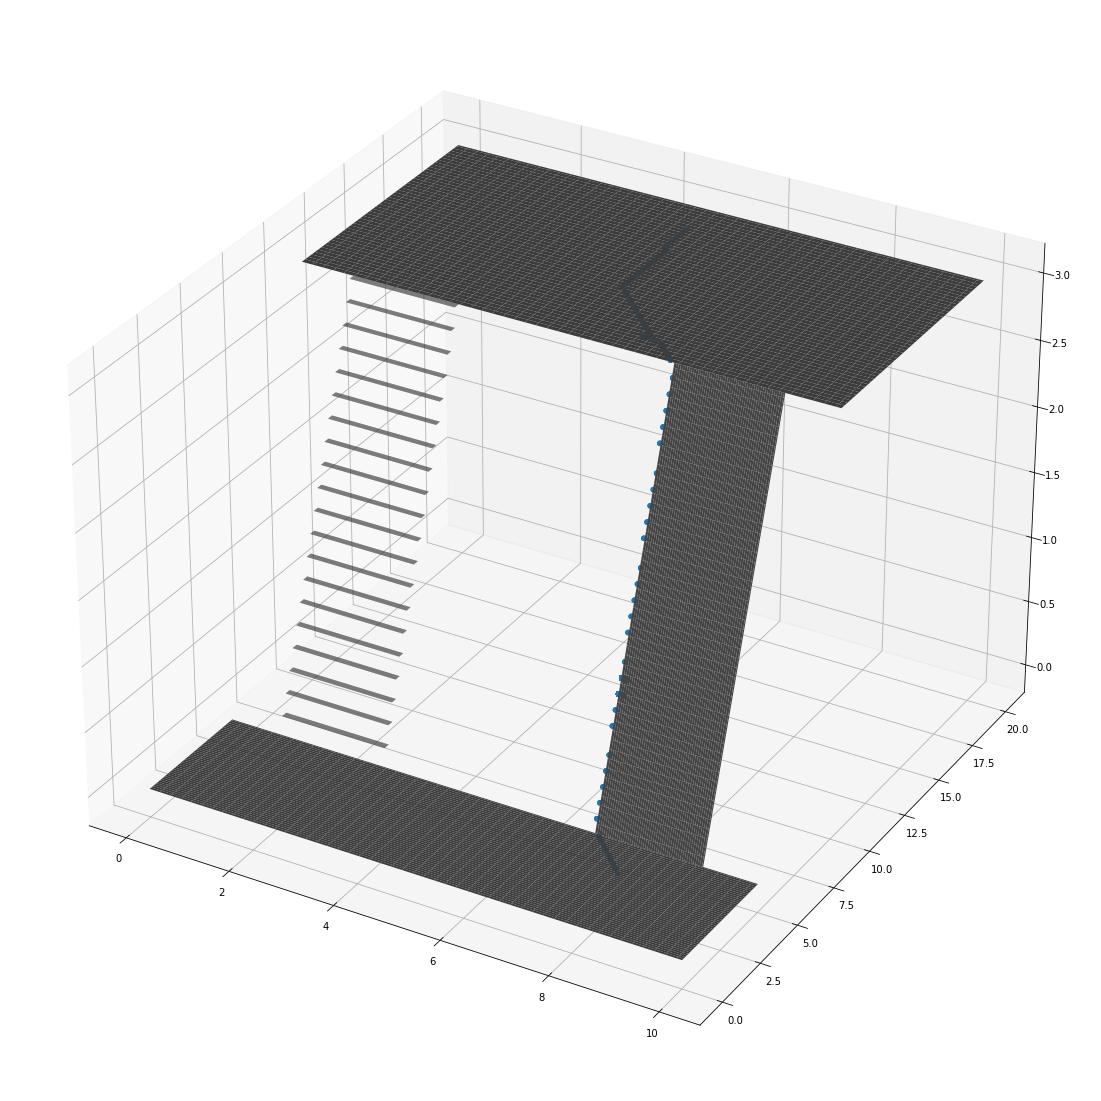

In [10]:
anyAStar.plotSearchProgress(3)

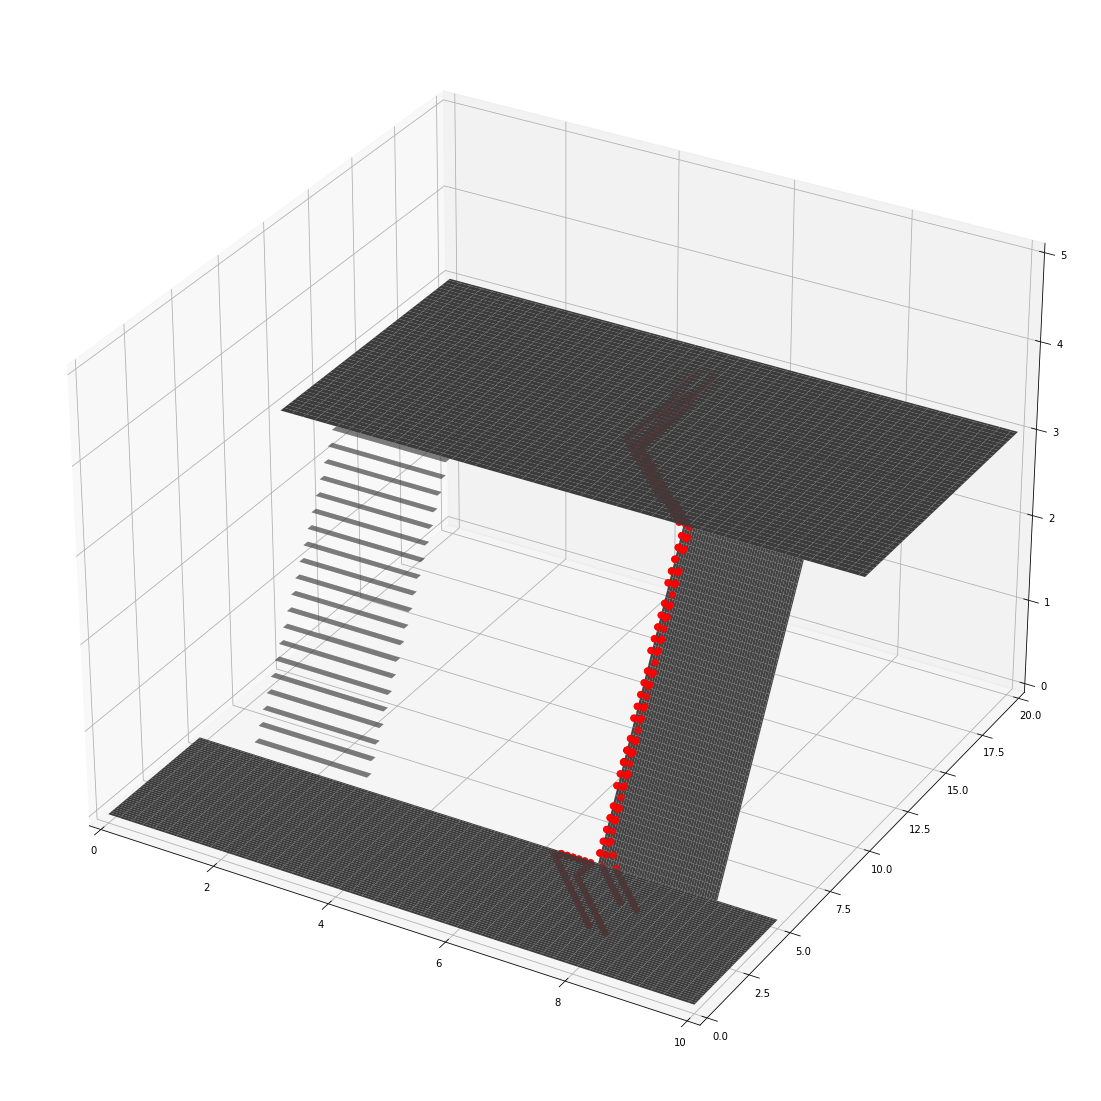

In [11]:
anyAStar.plotOptimalPath(2)